# 1.31f: Bulk Flow Correlation and Centroid Magnitude

**Question:** Do the ρ≈1 spikes in bulk flow correlation correspond to moments when the centroid actually moves?

**Hypothesis:** In Fimbulwinter (t≥400), tokens are mostly frozen. The binary switching between ρ≈0 and ρ≈1 reflects:
- **ρ≈1 spikes:** A few tokens hop together → centroid moves → perfect correlation
- **ρ≈0 gaps:** Most tokens frozen → centroid stationary → undefined correlation

We'll plot ρ_bulk(t) and |ΔC|(t) on the same timescale to see if they're synchronized.

## Parameters

In [1]:
THIMBLE_PATH = "../tensors/Thimble/thimble_7.h5"
DPI = 200

## Imports

In [2]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print(f"Loading data from {THIMBLE_PATH}...\n")

with h5py.File(THIMBLE_PATH, 'r') as f:
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    W_all = torch.from_numpy(f['W'][:]).view(torch.bfloat16)
    W_dead = W_all[:, dead_mask, :].to(torch.float32).to(device)
    
print(f"✓ Loaded W: {W_dead.shape}")

Loading data from ../tensors/Thimble/thimble_7.h5...

✓ Loaded W: torch.Size([6001, 3699, 64])


## Compute Displacements and Centroid

In [5]:
# Token displacements
delta_W = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)

# Centroid displacement
delta_C = delta_W.mean(dim=1)  # (6000, 64)

# Centroid displacement magnitude
mag_C = torch.norm(delta_C, dim=1).cpu().numpy()  # (6000,)

print(f"✓ Computed ΔW and ΔC")
print(f"  |ΔC| range: [{mag_C.min():.2e}, {mag_C.max():.2e}]")

✓ Computed ΔW and ΔC
  |ΔC| range: [0.00e+00, 7.86e-03]


## Compute Bulk Flow Correlation

In [6]:
# Dot product
dot_product = (delta_W * delta_C.unsqueeze(1)).sum(dim=2)  # (6000, 3699)

# Magnitudes
mag_W = torch.norm(delta_W, dim=2)  # (6000, 3699)
mag_C_expanded = torch.norm(delta_C, dim=1).unsqueeze(1)  # (6000, 1)

# Correlation
rho_bulk = dot_product / (mag_W * mag_C_expanded + 1e-30)

# Median over tokens
median_rho = torch.median(rho_bulk, dim=1).values.cpu().numpy()  # (6000,)

print(f"✓ Computed ρ_bulk")

✓ Computed ρ_bulk


## Plot: Two-Panel Comparison

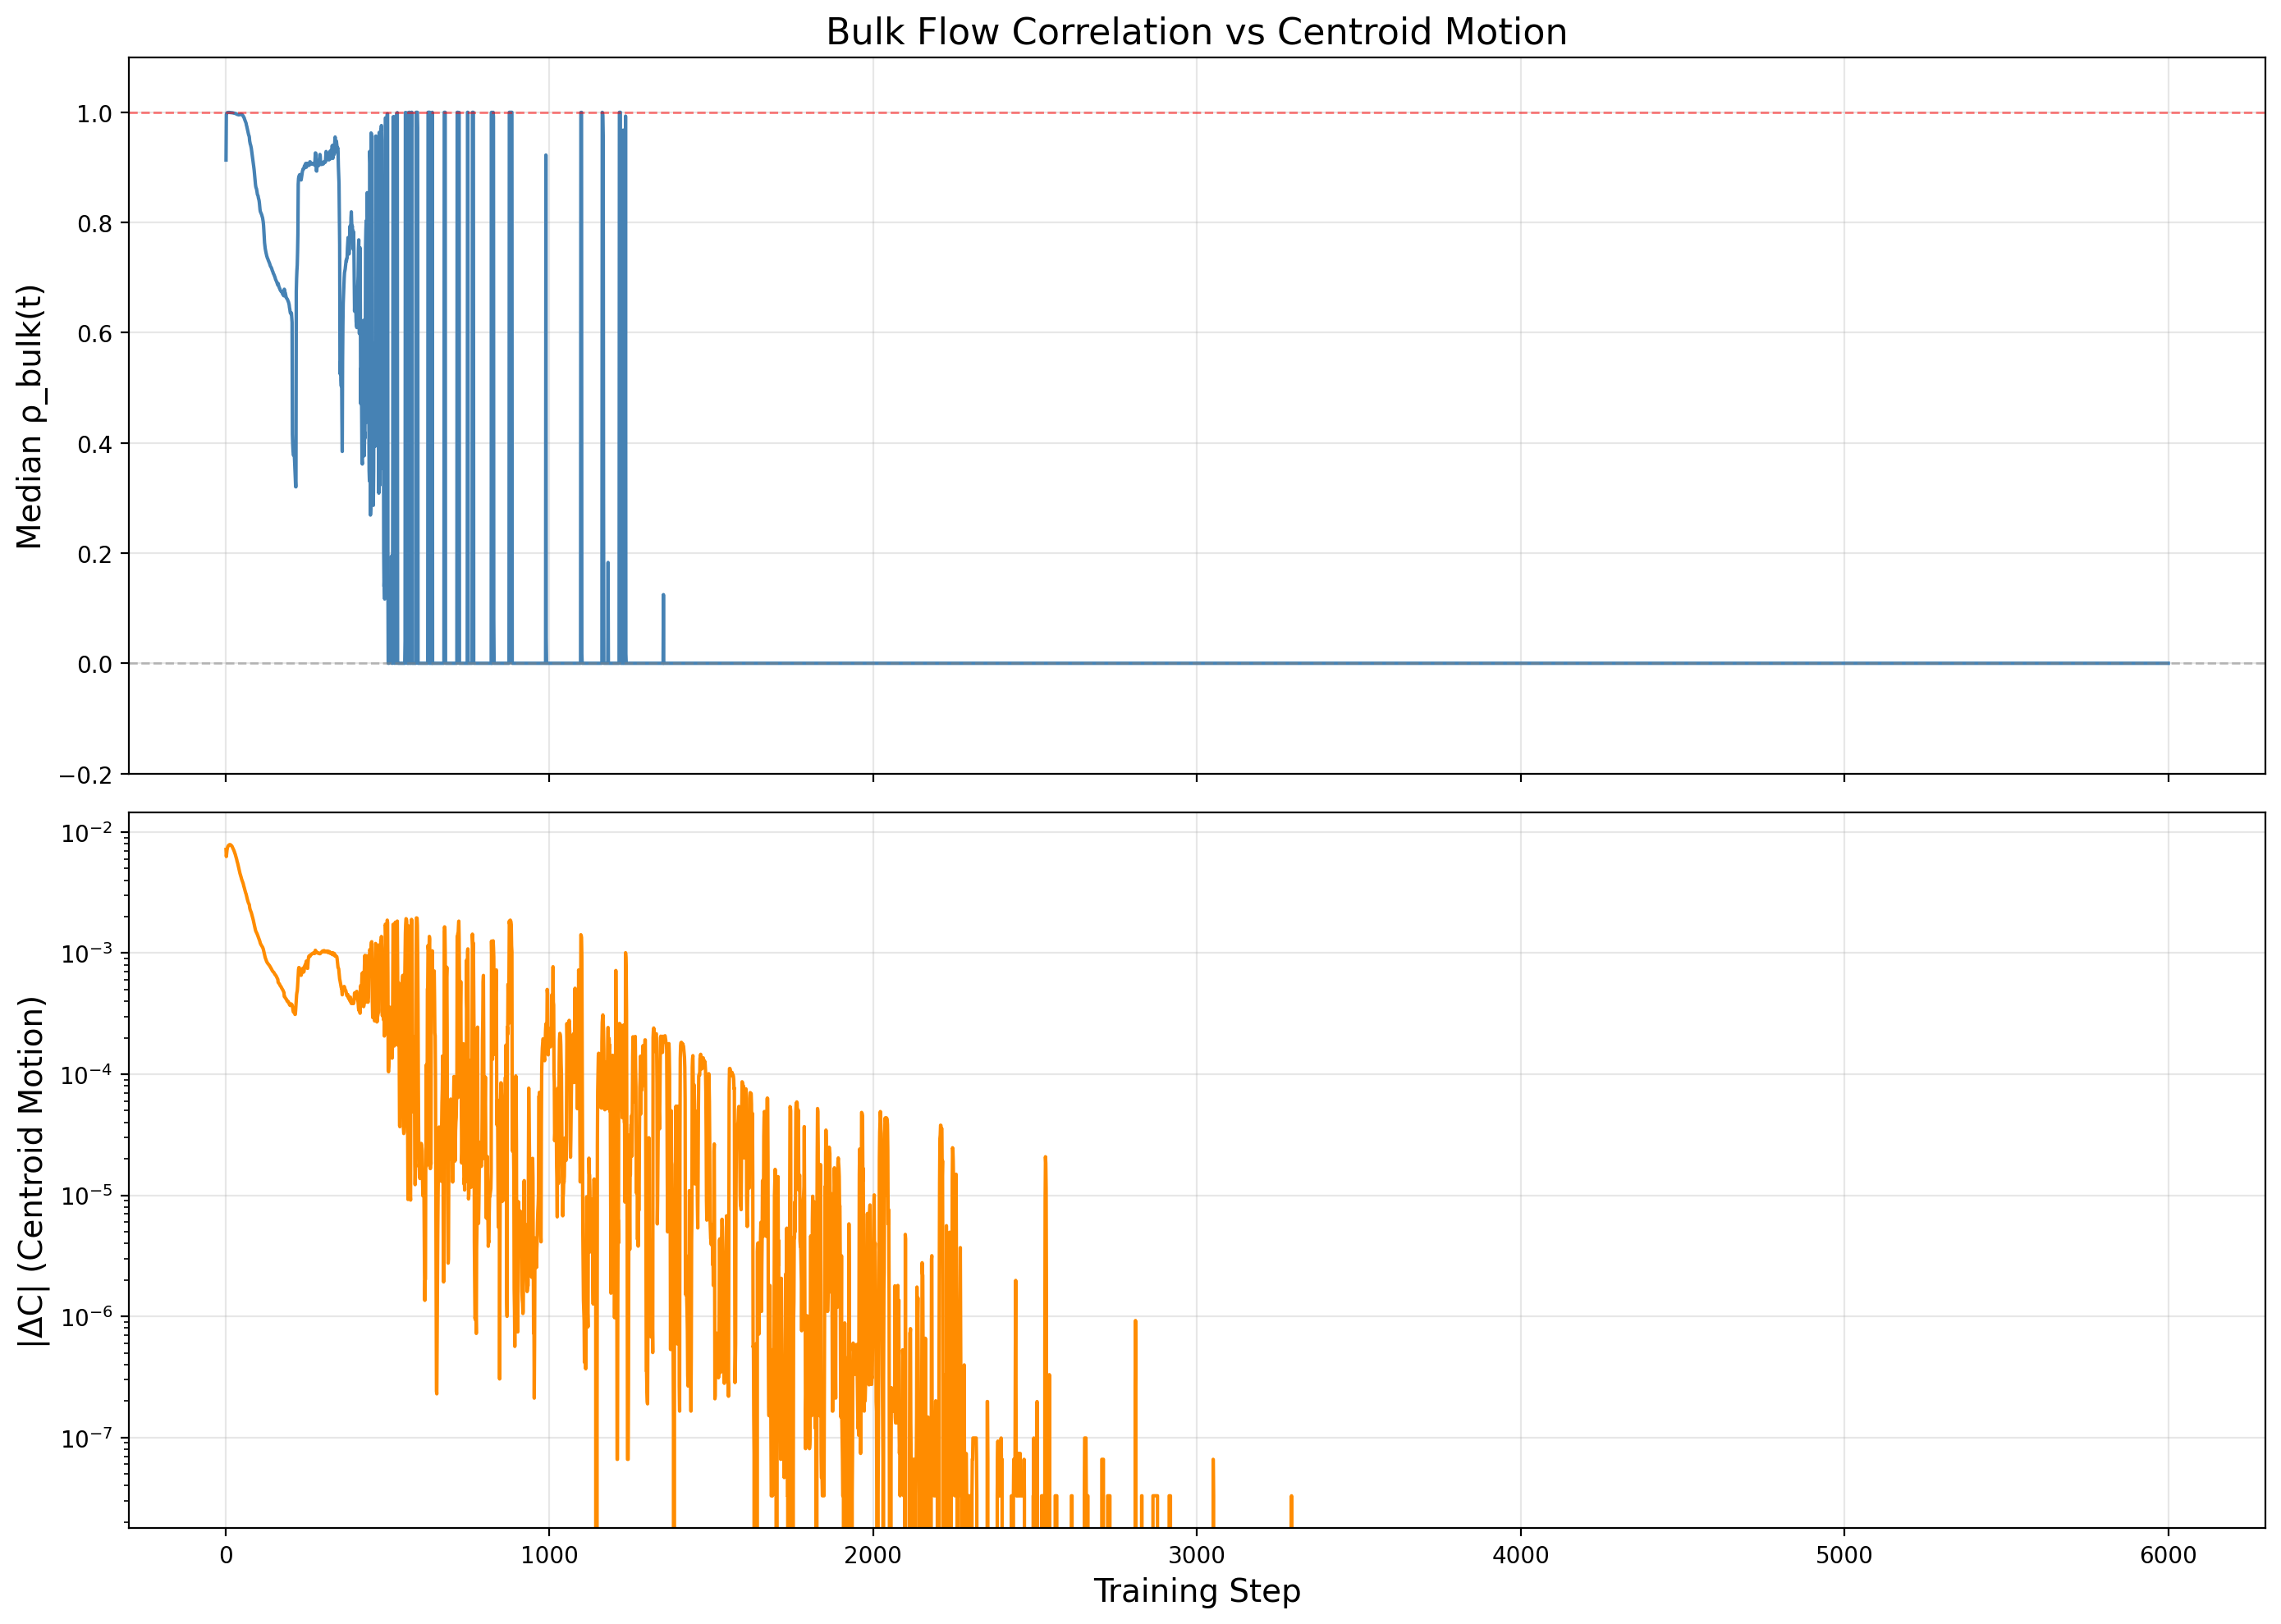

In [7]:
timesteps = np.arange(1, 6001)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=DPI, sharex=True)

# Top panel: Bulk flow correlation
ax1.plot(timesteps, median_rho, color='steelblue', linewidth=1.5)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylabel('Median ρ_bulk(t)', fontsize=14)
ax1.set_title('Bulk Flow Correlation vs Centroid Motion', fontsize=16)
ax1.set_ylim(-0.2, 1.1)
ax1.grid(True, alpha=0.3)

# Bottom panel: Centroid displacement magnitude
ax2.plot(timesteps, mag_C, color='darkorange', linewidth=1.5)
ax2.set_xlabel('Training Step', fontsize=14)
ax2.set_ylabel('|ΔC| (Centroid Motion)', fontsize=14)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Zoomed View: Fimbulwinter (t=400-1000)

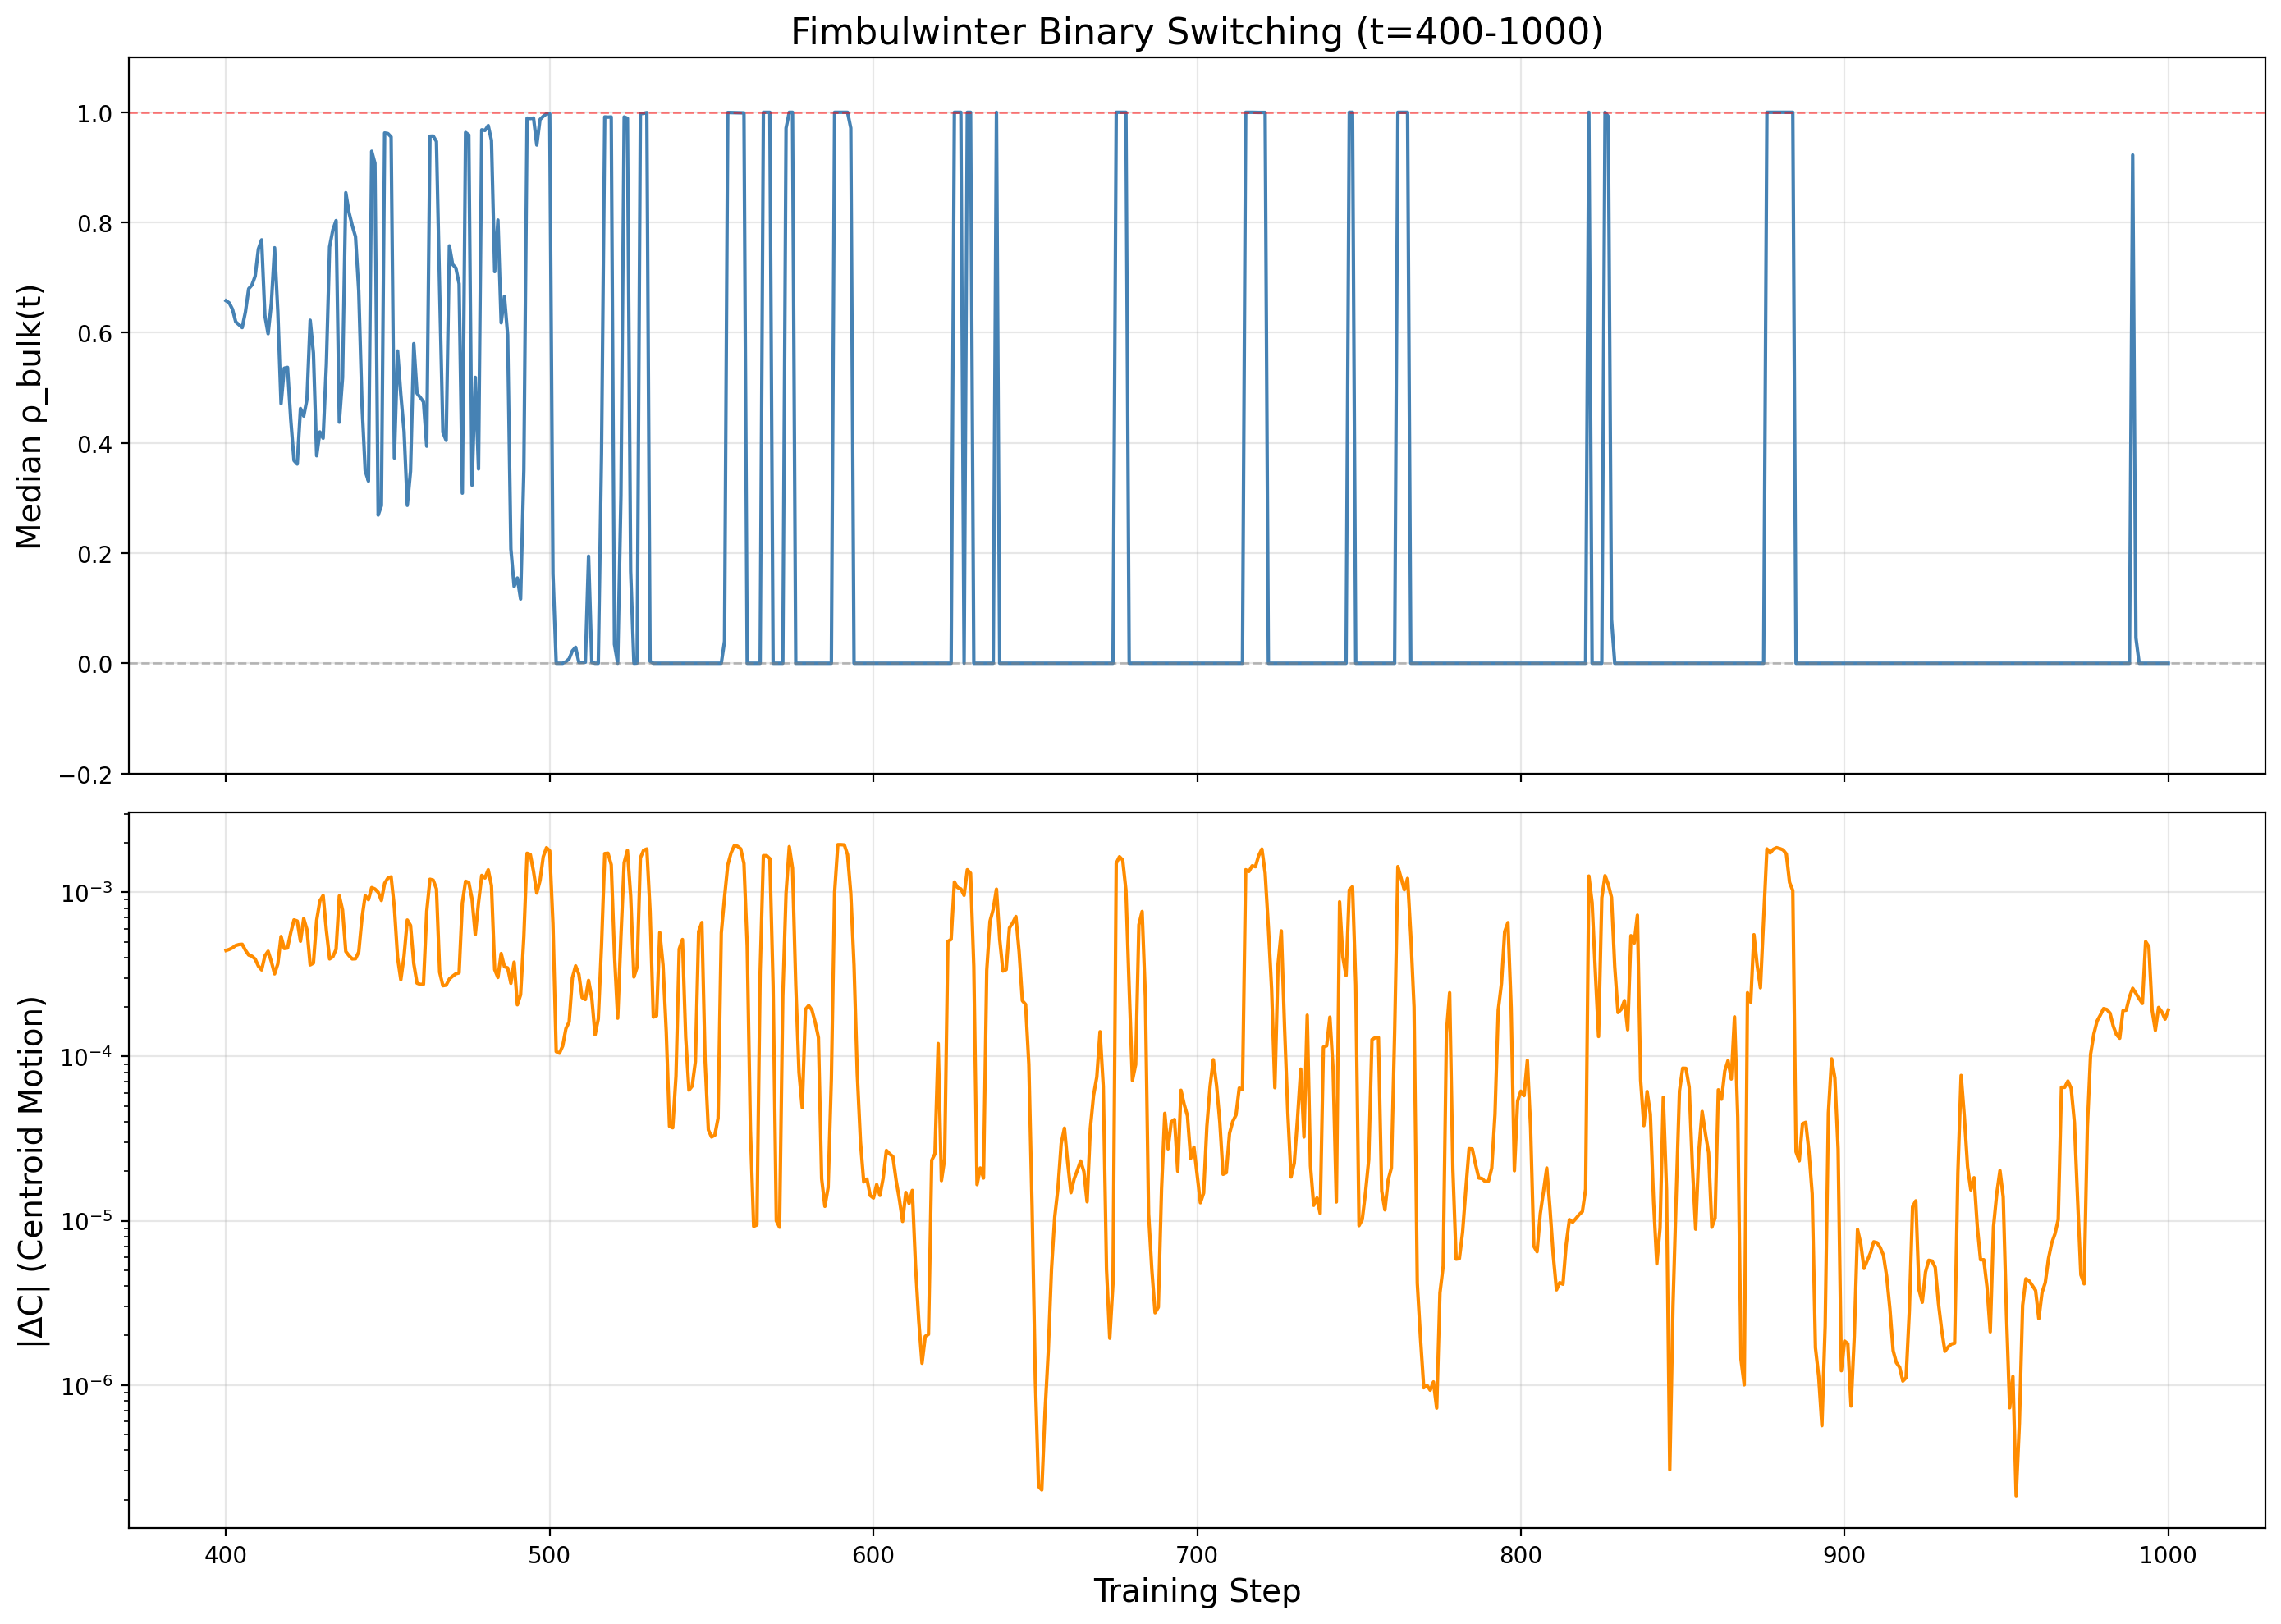

In [8]:
zoom_start = 400
zoom_end = 1000
zoom_mask = (timesteps >= zoom_start) & (timesteps <= zoom_end)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=DPI, sharex=True)

# Top: ρ_bulk
ax1.plot(timesteps[zoom_mask], median_rho[zoom_mask], color='steelblue', linewidth=1.5)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylabel('Median ρ_bulk(t)', fontsize=14)
ax1.set_title(f'Fimbulwinter Binary Switching (t={zoom_start}-{zoom_end})', fontsize=16)
ax1.set_ylim(-0.2, 1.1)
ax1.grid(True, alpha=0.3)

# Bottom: |ΔC|
ax2.plot(timesteps[zoom_mask], mag_C[zoom_mask], color='darkorange', linewidth=1.5)
ax2.set_xlabel('Training Step', fontsize=14)
ax2.set_ylabel('|ΔC| (Centroid Motion)', fontsize=14)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis: Correlation Between Spikes

In [9]:
# Focus on Fimbulwinter period
fimbul_start = 400
fimbul_mask = timesteps >= fimbul_start

rho_fimbul = median_rho[fimbul_mask]
mag_fimbul = mag_C[fimbul_mask]

# Identify "active" timesteps (centroid moving significantly)
threshold_mag = np.percentile(mag_fimbul, 50)  # Above median motion
active = mag_fimbul > threshold_mag

# Identify "correlated" timesteps (ρ > 0.5)
correlated = rho_fimbul > 0.5

# Overlap
both = active & correlated
n_active = active.sum()
n_correlated = correlated.sum()
n_both = both.sum()

print("=" * 80)
print(f"FIMBULWINTER ANALYSIS (t≥{fimbul_start})")
print("=" * 80)
print()
print(f"Timesteps with |ΔC| > median:  {n_active:4d}  (centroid active)")
print(f"Timesteps with ρ > 0.5:        {n_correlated:4d}  (high correlation)")
print(f"Both active AND correlated:    {n_both:4d}")
print()
print(f"When centroid is active, what % show high correlation?")
print(f"  {n_both / n_active * 100:.1f}%")
print()
print("Interpretation:")
if n_both / n_active > 0.7:
    print("  ✓ Strong correlation: ρ≈1 spikes happen when centroid moves")
    print("  → Binary switching is real: frozen tokens vs coordinated hops")
else:
    print("  ? Weak correlation: spikes don't align with centroid motion")
    print("  → Need different explanation")

print()
print("=" * 80)

FIMBULWINTER ANALYSIS (t≥400)

Timesteps with |ΔC| > median:  1930  (centroid active)
Timesteps with ρ > 0.5:         141  (high correlation)
Both active AND correlated:     141

When centroid is active, what % show high correlation?
  7.3%

Interpretation:
  ? Weak correlation: spikes don't align with centroid motion
  → Need different explanation

